In [64]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from quantile_forest import RandomForestQuantileRegressor
from sklearn.metrics import mean_pinball_loss


# load data
training_data = pd.read_csv('data/Training_Data_averaged.csv', index_col=0)
testing_data = pd.read_csv('data/Testing_Data_averaged.csv', index_col=0)

training_data_northwest = pd.read_csv('data/Training_Data_Northwest.csv', index_col=0)
testing_data_northwest = pd.read_csv('data/Testing_Data_Northwest.csv', index_col=0)
training_data_southeast = pd.read_csv('data/Training_Data_Southeast.csv', index_col=0)
training_data_southwest = pd.read_csv('data/Training_Data_Southwest.csv', index_col=0)
training_data_northeast = pd.read_csv('data/Training_Data_Northeast.csv', index_col=0)

# add column Total Wind [MW] which is sum of wind onshore and wind offshore 
training_data['Total Wind [MW]'] = training_data['Wind Onshore [MW]'] + training_data['Total Wind [MW]']
testing_data['Total Wind [MW]'] = testing_data['Wind Onshore [MW]'] + testing_data['Total Wind [MW]']

training_data_northwest['Total Wind [MW]'] = training_data_northwest['Wind Onshore [MW]'] + training_data_northwest['Wind Offshore [MW] ']
testing_data_northwest['Total Wind [MW]'] = testing_data_northwest['Wind Onshore [MW]'] + testing_data_northwest['Wind Offshore [MW] ']
training_data_southeast['Total Wind [MW]'] = training_data_southeast['Wind Onshore [MW]'] + training_data_southeast['Wind Offshore [MW] ']
training_data_southwest['Total Wind [MW]'] = training_data_southwest['Wind Onshore [MW]'] + training_data_southwest['Wind Offshore [MW] ']
training_data_northeast['Total Wind [MW]'] = training_data_northeast['Wind Onshore [MW]'] + training_data_northeast['Wind Offshore [MW] ']

print(training_data.head())

                          day      hour       msl       tcc       t2m  \
time                                                                    
2019-01-01 00:00:00 -1.727278 -1.661293  1.536836  1.409440 -0.660146   
2019-01-01 01:00:00 -1.727278 -1.516833  1.486795  1.377614 -0.646824   
2019-01-01 02:00:00 -1.727278 -1.372373  1.424867  1.410695 -0.661513   
2019-01-01 03:00:00 -1.727278 -1.227912  1.335549  1.464863 -0.670784   
2019-01-01 04:00:00 -1.727278 -1.083452  1.224283  1.475456 -0.676032   

                         ssr      sund      ws10     ws100  \
time                                                         
2019-01-01 00:00:00 -0.85915 -0.990967  0.825597  0.846255   
2019-01-01 01:00:00 -0.85915 -0.990967  0.980525  0.976528   
2019-01-01 02:00:00 -0.85915 -0.990967  1.147214  1.134154   
2019-01-01 03:00:00 -0.85915 -0.990967  1.353153  1.337304   
2019-01-01 04:00:00 -0.85915 -0.990967  1.551084  1.523818   

                     max Wind Offshore [MW]  max Wind

In [71]:

# make crossvalidation where two years are used for training and one year for testing

def train_model(x,y, x_test, y_test,  quantiles=[0.025, 0.5, 0.975], n_trees=100):
    qrf = RandomForestQuantileRegressor(n_estimators=n_trees)
    # delete column names
    x = x.values
    x_test = x_test.values
    y = y.values
    y_test = y_test.values
    qrf.fit(x, y)
    y_pred = qrf.predict(x_test, quantiles)
    y_train_pred = qrf.predict(x, quantiles)

    scores = []
    train_scores_res = []
    for q_index, q_value in enumerate(quantiles):
        score = mean_pinball_loss(y_true=y_test, y_pred=y_pred[:, q_index], alpha=q_value)
        train_score = mean_pinball_loss(y_true=y, y_pred=y_train_pred[:, q_index], alpha=q_value)
        scores.append(score)
        train_scores_res.append(train_score)

    return np.mean(scores), np.mean(train_scores_res), y_pred, y_train_pred


def train_and_predict(cv_combinations, quantiles, n_trees=100):
    result_scores = {'wind': [], 'photovoltaic': []}
    predictions = {'wind': [],  'photovoltaic': []}
    train_score_res = {'wind': [], 'photovoltaic': []}

    for train_data, test_data in cv_combinations:
        # predict wind 
        X_wind = train_data.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]', 'Total Wind [MW]'])
        y_wind = train_data['Total Wind [MW]']
        X_wind_test = test_data.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]', 'Total Wind [MW]'])
        y_wind_test = test_data['Total Wind [MW]']

    
        # predict photovoltaic
        X_photovoltaic = train_data.drop(columns=['year','Photovoltaic [MW]', 'Wind Onshore [MW]', 'Wind Offshore [MW] ', 'Total Wind [MW]'])
        y_photovoltaic = train_data['Photovoltaic [MW]']
        X_photovoltaic_test = test_data.drop(columns=['year','Photovoltaic [MW]', 'Wind Onshore [MW]', 'Wind Offshore [MW] ', 'Total Wind [MW]'])
        y_photovoltaic_test = test_data['Photovoltaic [MW]']

        # train models
        scores, train_scores, y_pred_wind, y_train_pred = train_model(X_wind, y_wind, X_wind_test, y_wind_test, quantiles=quantiles, n_trees=n_trees)

        result_scores['wind'].append(scores)
        train_score_res['wind'].append(train_scores)



        # now photovoltaic
        scores, train_scores, y_pred_photovoltaic, y_train_pred = train_model(X_photovoltaic, y_photovoltaic, X_photovoltaic_test, y_photovoltaic_test, quantiles=quantiles, n_trees=n_trees)

        result_scores['photovoltaic'].append(np.mean(scores))
        train_score_res['photovoltaic'].append(np.mean(train_scores))
    

    # average results
    result_scores['wind'] = np.mean(result_scores['wind'])
    result_scores['photovoltaic'] = np.mean(result_scores['photovoltaic'])
    print(result_scores)

    # average train scores
    train_score_res['wind'] = np.mean(train_score_res['wind'])
    train_score_res['photovoltaic'] = np.mean(train_score_res['photovoltaic'])

    predictions['wind'] = y_pred_wind
    predictions['photovoltaic'] = y_pred_photovoltaic

    return result_scores,train_score_res, predictions, y_train_pred


## Test for optimal tree numbers

Dataset taken is the mean over Germany

In [72]:
n_trees_list = [10, 50, 100, 200, 300, 400]
results_n_trees = {}
prediction_results_n_trees = {}
training_scores_n_trees = {}

training_data_one_hr = training_data.copy()

training_data_one_hr['Total Wind [MW]'] = training_data['Total Wind [MW]'].shift(-1)
training_data_one_hr['Photovoltaic [MW]'] = training_data['Photovoltaic [MW]'].shift(-1)

# drop last row
training_data_one_hr = training_data_one_hr.dropna()

training_data_2019 = training_data_one_hr[training_data_one_hr['year'] == 2019]
training_data_2020 = training_data_one_hr[training_data_one_hr['year'] == 2020]
training_data_2021 = training_data_one_hr[training_data_one_hr['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

quantiles = [0.025, 0.5, 0.975]
for n_trees in n_trees_list:
    print(f"Training with {n_trees} trees")
    results_n_trees[str(n_trees)], prediction_results_n_trees[str(n_trees)], training_scores_n_trees[str(n_trees)], _ = train_and_predict(combinations, quantiles, n_trees)






Training with 10 trees
{'wind': 808.3810398961282, 'photovoltaic': 186.60124163988095}
Training with 50 trees
{'wind': 696.4901622041685, 'photovoltaic': 160.26452487961308}
Training with 100 trees
{'wind': 686.4743253290786, 'photovoltaic': 159.2537210160158}
Training with 200 trees
{'wind': 680.2098469145925, 'photovoltaic': 157.52011435791118}
Training with 300 trees
{'wind': 677.9086195079054, 'photovoltaic': 156.8565910748379}
Training with 400 trees
{'wind': 678.2053834174567, 'photovoltaic': 156.3672585891671}


In [73]:

training_data_one_day = training_data.copy()

training_data_one_day['Total Wind [MW]'] = training_data['Total Wind [MW]'].shift(-24)
training_data_one_day['Photovoltaic [MW]'] = training_data['Photovoltaic [MW]'].shift(-24)

# drop last row
training_data_one_day = training_data_one_day.dropna()

training_data_2019 = training_data_one_day[training_data_one_day['year'] == 2019]
training_data_2020 = training_data_one_day[training_data_one_day['year'] == 2020]
training_data_2021 = training_data_one_day[training_data_one_day['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

for n_trees in n_trees_list:
    print(f"Training with {n_trees} trees")
    results_n_trees[str(n_trees)+'_24hr'], prediction_results_n_trees[str(n_trees)+'_24hr'], training_scores_n_trees[str(n_trees)+'_24hr'], _ = train_and_predict(combinations, quantiles, n_trees)

Training with 10 trees
{'wind': 1965.0913220282837, 'photovoltaic': 300.42639651538616}
Training with 50 trees
{'wind': 1674.0778895622236, 'photovoltaic': 261.2690508848023}
Training with 100 trees
{'wind': 1644.3711051976397, 'photovoltaic': 256.13908429554846}
Training with 200 trees
{'wind': 1631.689219498263, 'photovoltaic': 255.4693080911602}
Training with 300 trees
{'wind': 1623.4901859337012, 'photovoltaic': 253.37030089226286}
Training with 400 trees
{'wind': 1622.3702528006218, 'photovoltaic': 253.16708471823983}


{'10': 815.1250000199198, '50': 698.0254068827019, '100': 686.5595589595706, '200': 681.2221222154817, '300': 677.9064243521768, '400': 677.5274948813714}


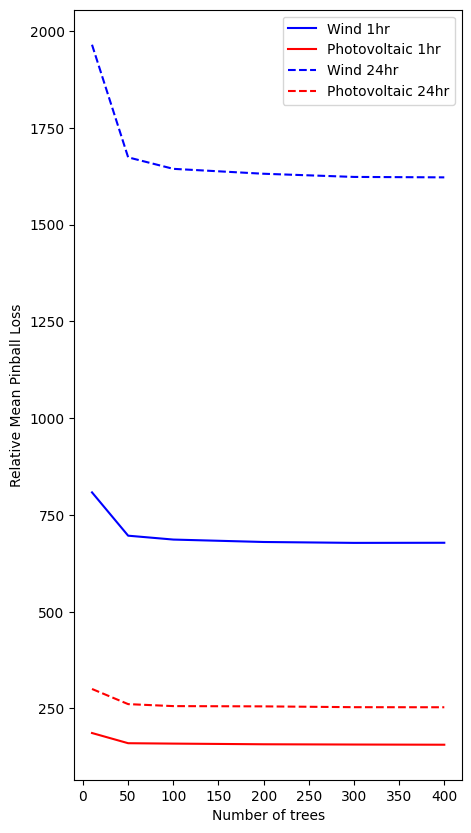

In [161]:
# plot losses for different n_trees

n_trees_list = [10, 50, 100, 200, 300, 400]


wind_losses = [results_n_trees[str(n_trees)]['wind'] for n_trees in n_trees_list]
photovoltaic_losses = [results_n_trees[str(n_trees)]['photovoltaic'] for n_trees in n_trees_list]

wind_losses_24hr = [results_n_trees[str(n_trees)+'_24hr']['wind'] for n_trees in n_trees_list]
photovoltaic_losses_24hr = [results_n_trees[str(n_trees)+'_24hr']['photovoltaic'] for n_trees in n_trees_list]

plt.figure(figsize=(5, 10))
plt.plot(n_trees_list, wind_losses, label='Wind 1hr', color='blue')
plt.plot(n_trees_list, photovoltaic_losses, label='Photovoltaic 1hr', color='red')#
plt.plot(n_trees_list, wind_losses_24hr, label='Wind 24hr', color='blue', linestyle='dashed')
plt.plot(n_trees_list, photovoltaic_losses_24hr, label='Photovoltaic 24hr', color='red', linestyle='dashed')
plt.xlabel('Number of trees')
plt.ylabel('Relative Mean Pinball Loss')
plt.legend()

# save results
results_df = pd.DataFrame(results_n_trees)
results_df.to_csv('results/results_n_trees.csv')
# save plot

plt.savefig('results/n_trees_mean_pinball_loss.png')

mean_loss_trees = {}
# print means of the losses per ntree
for tree in range(6):
    tree = n_trees_list[tree]
    results = []
    results.append(results_n_trees[str(tree)]['wind'])
    results.append(results_n_trees[str(tree)]['photovoltaic'])
    results.append(results_n_trees[str(tree)+'_24hr']['wind'])
    results.append(results_n_trees[str(tree)+'_24hr']['photovoltaic'])

    mean_loss_trees[str(tree)] = np.mean(results)

print(mean_loss_trees)
    

In [76]:
# predict one hour in the future
#take training data and shift targets by one hour

final_result = {}
prediction_results = {}
training_scores = {}

n_trees = 300

training_data_one_hr = training_data.copy()

training_data_one_hr['Total Wind [MW]'] = training_data['Total Wind [MW]'].shift(-1)
training_data_one_hr['Photovoltaic [MW]'] = training_data['Photovoltaic [MW]'].shift(-1)

# drop last row
training_data_one_hr = training_data_one_hr.dropna()

training_data_2019 = training_data_one_hr[training_data_one_hr['year'] == 2019]
training_data_2020 = training_data_one_hr[training_data_one_hr['year'] == 2020]
training_data_2021 = training_data_one_hr[training_data_one_hr['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

quantiles = [0.025, 0.5, 0.975]

final_result['mean_loc_1_hr'], training_scores['mean_loc_1_hr'], prediction_results['mean_loc_1_hr'], _ = train_and_predict(combinations, quantiles, n_trees)

{'wind': 679.31954261986, 'photovoltaic': 156.91515999515016}


In [77]:
# # predict 24 hour in the future
#take training data and shift targets by one hour

training_data_one_day = training_data.copy()

training_data_one_day['Total Wind [MW]'] = training_data['Total Wind [MW]'].shift(-24)
training_data_one_day['Photovoltaic [MW]'] = training_data['Photovoltaic [MW]'].shift(-24)

# drop last row
training_data_one_day = training_data_one_day.dropna()

training_data_2019 = training_data_one_day[training_data_one_day['year'] == 2019]
training_data_2020 = training_data_one_day[training_data_one_day['year'] == 2020]
training_data_2021 = training_data_one_day[training_data_one_day['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['mean_loc_24_hr'], training_scores['mean_loc_24_hr'], prediction_results['mean_loc_24_hr'], _ = train_and_predict(combinations, quantiles, n_trees)


{'wind': 1624.8422536752475, 'photovoltaic': 253.91506227859566}


# North West


In [78]:
# predict one hour in the future
#take training data and shift targets by one hour
training_data_one_hr = training_data_northwest.copy()

training_data_one_hr['Total Wind [MW]'] = training_data_northwest['Total Wind [MW]'].shift(-1)
training_data_one_hr['Photovoltaic [MW]'] = training_data_northwest['Photovoltaic [MW]'].shift(-1)

# drop last row
training_data_one_hr = training_data_one_hr.dropna()

training_data_2019 = training_data_one_hr[training_data_one_hr['year'] == 2019]
training_data_2020 = training_data_one_hr[training_data_one_hr['year'] == 2020]
training_data_2021 = training_data_one_hr[training_data_one_hr['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['northwest_1_hr'], training_scores['northwest_1_hr'], prediction_results['northwest_1_hr'], _ = train_and_predict(combinations, quantiles, n_trees)

{'wind': 619.3313575888127, 'photovoltaic': 233.5056914887291}


In [79]:
# # predict 24 hour in the future
#take training data and shift targets by one hour

training_data_one_day = training_data_northwest.copy()

training_data_one_day['Total Wind [MW]'] = training_data_northwest['Total Wind [MW]'].shift(-24)
training_data_one_day['Photovoltaic [MW]'] = training_data_northwest['Photovoltaic [MW]'].shift(-24)

training_data_one_day = training_data_one_day.dropna()

training_data_2019 = training_data_one_day[training_data_one_day['year'] == 2019]
training_data_2020 = training_data_one_day[training_data_one_day['year'] == 2020]
training_data_2021 = training_data_one_day[training_data_one_day['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['northwest_24_hr'], training_scores['northwest_24_hr'], prediction_results['northwest_24_hr'], _ = train_and_predict(combinations, quantiles, n_trees)

{'wind': 1624.6924614694583, 'photovoltaic': 253.9796573380813}


# North East


In [80]:
# predict one hour in the future
#take training data and shift targets by one hour
training_data_one_hr = training_data_northeast.copy()

training_data_one_hr['Total Wind [MW]'] = training_data_northeast['Total Wind [MW]'].shift(-1)
training_data_one_hr['Photovoltaic [MW]'] = training_data_northeast['Photovoltaic [MW]'].shift(-1)

# drop last row
training_data_one_hr = training_data_one_hr.dropna()

training_data_2019 = training_data_one_hr[training_data_one_hr['year'] == 2019]
training_data_2020 = training_data_one_hr[training_data_one_hr['year'] == 2020]
training_data_2021 = training_data_one_hr[training_data_one_hr['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['northeast_1_hr'], training_scores['northeast_1_hr'], prediction_results['northeast_1_hr'], _ = train_and_predict(combinations, quantiles, n_trees)

{'wind': 845.3966001541745, 'photovoltaic': 222.3466902057904}


In [81]:
# # predict 24 hour in the future
#take training data and shift targets by one hour

training_data_one_day = training_data_northeast.copy()

training_data_one_day['Total Wind [MW]'] = training_data_northeast['Total Wind [MW]'].shift(-24)
training_data_one_day['Photovoltaic [MW]'] = training_data_northeast['Photovoltaic [MW]'].shift(-24)


training_data_one_day = training_data_one_day.dropna()

training_data_2019 = training_data_one_day[training_data_one_day['year'] == 2019]
training_data_2020 = training_data_one_day[training_data_one_day['year'] == 2020]
training_data_2021 = training_data_one_day[training_data_one_day['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['northeast_24_hr'], training_scores['northeast_24_hr'], prediction_results['northeast_24_hr'], _ = train_and_predict(combinations, quantiles, n_trees)

{'wind': 1740.3652499029176, 'photovoltaic': 259.98267679004465}


# South West

In [82]:
# predict one hour in the future
#take training data and shift targets by one hour
training_data_one_hr = training_data_southwest.copy()

training_data_one_hr['Total Wind [MW]'] = training_data_southwest['Total Wind [MW]'].shift(-1)
training_data_one_hr['Photovoltaic [MW]'] = training_data_southwest['Photovoltaic [MW]'].shift(-1)

# drop last row
training_data_one_hr = training_data_one_hr.dropna()

training_data_2019 = training_data_one_hr[training_data_one_hr['year'] == 2019]
training_data_2020 = training_data_one_hr[training_data_one_hr['year'] == 2020]
training_data_2021 = training_data_one_hr[training_data_one_hr['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['southwest_1_hr'], training_scores['southwest_1_hr'], prediction_results['southwest_1_hr'], _ = train_and_predict(combinations, quantiles, n_trees)

{'wind': 1327.3321442899698, 'photovoltaic': 197.84038687629572}


In [83]:
# # predict 24 hour in the future
#take training data and shift targets by one hour

training_data_one_day = training_data_southwest.copy()

training_data_one_day['Total Wind [MW]'] = training_data_southwest['Total Wind [MW]'].shift(-24)
training_data_one_day['Photovoltaic [MW]'] = training_data_southwest['Photovoltaic [MW]'].shift(-24)

training_data_one_day = training_data_one_day.dropna()

training_data_2019 = training_data_one_day[training_data_one_day['year'] == 2019]
training_data_2020 = training_data_one_day[training_data_one_day['year'] == 2020]
training_data_2021 = training_data_one_day[training_data_one_day['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['southwest_24_hr'], training_scores['southwest_24_hr'], prediction_results['southwest_24_hr'], _ = train_and_predict(combinations, quantiles, n_trees)

{'wind': 1748.618623378428, 'photovoltaic': 268.3280851609831}


# South East

In [84]:
# predict one hour in the future
#take training data and shift targets by one hour
training_data_one_hr = training_data_southeast.copy()

training_data_one_hr['Total Wind [MW]'] = training_data_southeast['Total Wind [MW]'].shift(-1)
training_data_one_hr['Photovoltaic [MW]'] = training_data_southeast['Photovoltaic [MW]'].shift(-1)

# drop last row
training_data_one_hr = training_data_one_hr.dropna()

training_data_2019 = training_data_one_hr[training_data_one_hr['year'] == 2019]
training_data_2020 = training_data_one_hr[training_data_one_hr['year'] == 2020]
training_data_2021 = training_data_one_hr[training_data_one_hr['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['southeast_1_hr'], training_scores['southeast_1_hr'], prediction_results['southeast_1_hr'], _ = train_and_predict(combinations, quantiles, n_trees)

{'wind': 1454.6869069262812, 'photovoltaic': 203.46919301768014}


In [85]:
# # predict 24 hour in the future
#take training data and shift targets by one hour

training_data_one_day = training_data_southeast.copy()

training_data_one_day['Total Wind [MW]'] = training_data_southeast['Total Wind [MW]'].shift(-24)
training_data_one_day['Photovoltaic [MW]'] = training_data_southeast['Photovoltaic [MW]'].shift(-24)

training_data_one_day = training_data_one_day.dropna()

training_data_2019 = training_data_one_day[training_data_one_day['year'] == 2019]
training_data_2020 = training_data_one_day[training_data_one_day['year'] == 2020]
training_data_2021 = training_data_one_day[training_data_one_day['year'] == 2021]

combinations = [
    (pd.concat([training_data_2019, training_data_2020]), training_data_2021),
    (pd.concat([training_data_2019, training_data_2021]), training_data_2020),
    (pd.concat([training_data_2020, training_data_2021]), training_data_2019),
]

final_result['southeast_24_hr'], training_scores['southeast_24_hr'], prediction_results['southeast_24_hr'], _ = train_and_predict(combinations, quantiles, n_trees)

{'wind': 1916.7620248058904, 'photovoltaic': 272.9703930272829}


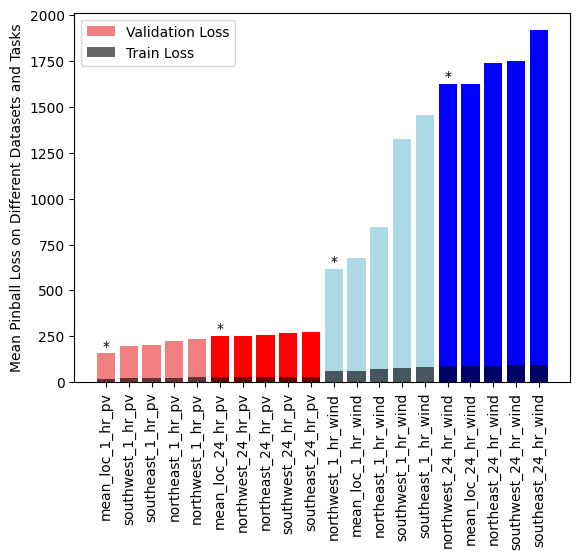

In [103]:
#print(final_result)
#print(prediction_results)

# plot results
df = pd.DataFrame(final_result)
df = df.T
df = df.reset_index()
#df.columns = ['location', 'mean_pinball_loss']

# make df longer for plotting
df = pd.melt(df, id_vars=['index'], value_vars=['wind', 'photovoltaic'])
df = df.sort_values(by='value')

df_train = pd.DataFrame(training_scores)
df_train = df_train.T
df_train = df_train.reset_index()

df_train = pd.melt(df_train, id_vars=['index'], value_vars=['wind', 'photovoltaic'])
df_train = df_train.sort_values(by='value')
# make plot for wind 




df.to_csv('results/mean_pinball_loss.csv', index=False)
df_train.to_csv('results/training_mean_pinball_loss.csv', index=False)

# plot all of the values in one bar graph
# make color by variable
data = pd.read_csv('results/mean_pinball_loss.csv')
train_data = pd.read_csv('results/training_mean_pinball_loss.csv')

x = data['index'].values
# add _pv to index name if variable == photovoltaic
for i in range(len(x)):
    if data['variable'].values[i] == 'photovoltaic':
        x[i] = x[i] + '_pv'
    if data['variable'].values[i] == 'wind':
        x[i] = x[i] + '_wind'

    
colors = []
for index in range(len(x)):
    if data['variable'].values[index] == 'photovoltaic':
        if '_1_hr' in x[index]:
            colors.append('lightcoral')
        else:
            colors.append('red')
    
    if data['variable'].values[index] == 'wind':
        if '_1_hr' in x[index]:
            colors.append('lightblue')
        else:
            colors.append('blue')


plt.bar(x, data['value'].values, color=colors, label = 'Validation Loss')

# add grey bars for train loss
plt.bar(x, train_data['value'].values, color='black', alpha = 0.6, label = 'Train Loss')

# add asteriks at indexes 0, 3, 7
marking = [0, 5, 10, 15]
for mark in marking:
    plt.text(mark, data['value'].values[mark], '*', ha='center', va='bottom')

# ylabel is mean pinball loss on validation set
plt.ylabel('Mean Pinball Loss on Different Datasets and Tasks')

# turn x labels 90 degrees
plt.xticks(rotation=90);
plt.legend();

# save the plot
plt.savefig('results/mean_pinball_loss.png', bbox_inches='tight')


# based on these results, will now predict on the test data

using the following training data:
- wind 1hr: northwest
- wind 24hrs: northwest
- photovoltaic 1 hr: mean
- photovoltaic 24hrs: northwest

The models will train on the whole 3 years now and will be tested on the 2022 dataset

In [110]:
training_data_one_hr_mean = training_data.copy()
training_data_one_hr_nw = training_data_northwest.copy()

training_data_one_hr_mean['Photovoltaic [MW]'] = training_data['Photovoltaic [MW]'].shift(-1)
training_data_one_hr_mean = training_data_one_hr_mean.dropna()

training_data_one_hr_nw['Total Wind [MW]'] = training_data_northwest['Total Wind [MW]'].shift(-1)
training_data_one_hr_nw = training_data_one_hr_nw.dropna()


testing_data_one_hr_nw = testing_data_northwest.copy()
testing_data_one_hr_mean = testing_data.copy()

testing_data_one_hr_nw['Total Wind [MW]'] = testing_data_northwest['Total Wind [MW]'].shift(-1)
testing_data_one_hr_mean['Photovoltaic [MW]'] = testing_data['Photovoltaic [MW]'].shift(-1)# drop last row
testing_data_one_hr_mean = testing_data_one_hr_mean.dropna()
testing_data_one_hr_nw = testing_data_one_hr_nw.dropna()

# 24 hrs
training_data_one_day_mean = training_data.copy()
training_data_one_day_nw = training_data_northwest.copy()

training_data_one_day_mean['Photovoltaic [MW]'] = training_data['Photovoltaic [MW]'].shift(-24)

training_data_one_day_nw['Total Wind [MW]'] = training_data_northwest['Total Wind [MW]'].shift(-24)

testing_data_one_day_mean = testing_data.copy()
testing_data_one_day_nw = testing_data_northwest.copy()

testing_data_one_day_nw['Total Wind [MW]'] = testing_data_northwest['Total Wind [MW]'].shift(-24)
testing_data_one_day_mean['Photovoltaic [MW]'] = testing_data['Photovoltaic [MW]'].shift(-24)


# drop last rows
training_data_one_day_mean = training_data_one_day_mean.dropna()
training_data_one_day_nw = training_data_one_day_nw.dropna()
testing_data_one_day_mean = testing_data_one_day_mean.dropna()
testing_data_one_day_nw = testing_data_one_day_nw.dropna()






In [111]:
# wind 1 hr
loss_2022 = {}
predictions_2022 = {}
train_scores_2022 = {}
y_train_preds_2022 = {}

X_wind_1hr = training_data_one_hr_nw.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]', 'Total Wind [MW]'])
y_wind_1hr = training_data_one_hr_nw['Total Wind [MW]']

X_wind_test_1hr = testing_data_one_hr_nw.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]', 'Total Wind [MW]'])
y_wind_test_1hr = testing_data_one_hr_nw['Total Wind [MW]']

scores, train_scores, y_pred, y_train_pred = train_model(X_wind_1hr, y_wind_1hr, X_wind_test_1hr, y_wind_test_1hr, quantiles, n_trees)

print('Wind 1 hr prediction')
print(scores)

loss_2022['wind_1_hr'] = scores
predictions_2022['wind_1_hr'] = y_pred
train_scores_2022['wind_1_hr'] = train_scores
y_train_preds_2022['wind_1_hr'] = y_train_pred

# wind  24 hrs
X_wind_24hr = training_data_one_day_nw.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]', 'Total Wind [MW]'])
y_wind_24hr = training_data_one_day_nw['Total Wind [MW]']

X_wind_test_24hr = testing_data_one_day_nw.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]', 'Total Wind [MW]'])
y_wind_test_24hr = testing_data_one_day_nw['Total Wind [MW]']

scores, train_scores, y_pred, y_train_pred = train_model(X_wind_24hr, y_wind_24hr, X_wind_test_24hr, y_wind_test_24hr, quantiles, n_trees)

print('Wind 24 hr prediction')
print(scores)

loss_2022['wind_24_hr'] = scores
predictions_2022['wind_24_hr'] = y_pred
train_scores_2022['wind_24_hr'] = train_scores
y_train_preds_2022['wind_24_hr'] = y_train_pred



# photovoltaic
X_photovoltaic_1_hr = training_data_one_hr_mean.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]', 'Total Wind [MW]'])
y_photovoltaic_1_hr = training_data_one_hr_mean['Photovoltaic [MW]']

X_photovoltaic_test_1_hr = testing_data_one_hr_mean.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]', 'Total Wind [MW]'])
y_photovoltaic_test_1_hr = testing_data_one_hr_mean['Photovoltaic [MW]']

scores, train_scores, y_pred, y_train_pred = train_model(X_photovoltaic_1_hr, y_photovoltaic_1_hr, X_photovoltaic_test_1_hr, y_photovoltaic_test_1_hr,quantiles,  n_trees)

print('Photovoltaic 1 hr prediction')
print(scores)

loss_2022['photovoltaic_1_hr'] = scores
predictions_2022['photovoltaic_1_hr'] = y_pred
train_scores_2022['photovoltaic_1_hr'] = train_scores
y_train_preds_2022['photovoltaic_1_hr'] = y_train_pred

# photovoltaic 24 hrs

X_photovoltaic_24_hr = training_data_one_day_mean.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]', 'Total Wind [MW]'])
y_photovoltaic_24_hr = training_data_one_day_mean['Photovoltaic [MW]']

X_photovoltaic_test_24_hr = testing_data_one_day_mean.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]', 'Total Wind [MW]'])
y_photovoltaic_test_24_hr = testing_data_one_day_mean['Photovoltaic [MW]']

scores, train_scores, y_pred, y_train_pred = train_model(X_photovoltaic_24_hr, y_photovoltaic_24_hr, X_photovoltaic_test_24_hr, y_photovoltaic_test_24_hr, quantiles, n_trees)

print('Photovoltaic 24 hr prediction')
print(scores)

loss_2022['photovoltaic_24_hr'] = scores
predictions_2022['photovoltaic_24_hr'] = y_pred
train_scores_2022['photovoltaic_24_hr'] = train_scores
y_train_preds_2022['photovoltaic_24_hr'] = y_train_pred






Wind 1 hr prediction
610.8237757116491
Wind 24 hr prediction
1447.7172931392608
Photovoltaic 1 hr prediction
203.16575608540745
Photovoltaic 24 hr prediction
320.21005916609437


In [112]:
# now put wind on and offshore together
# wind true

"""testing_data_one_hr_wind_total = testing_data_one_hr['Wind Offshore [MW] '] + testing_data_one_hr['Wind Onshore [MW]']
predicted_wind_total_1_hr = predictions_2022['offshore_1_hr'] + predictions_2022['onshore_1_hr']

scores = []
train_scores = []
for q_index, q_value in enumerate(quantiles):
    score = mean_pinball_loss(y_true=testing_data_one_hr_wind_total, y_pred=predicted_wind_total_1_hr[:, q_index], alpha=q_value)
    scores.append(score)
    train_scores.append(mean_pinball_loss(y_true=y_train_preds_2022['wind_total_1_hr'], y_pred=testing_data_one_hr_wind_total, alpha=q_value))

print('Wind 1 hr prediction')
print(np.mean(scores))

loss_2022['wind_total_1_hr'] = np.mean(scores)
train_scores_2022['wind_total_1_hr'] = np.mean(train_scores)

# wind true 24hrs
testing_data_one_day_wind_total = testing_data_one_day['Wind Offshore [MW] '] + testing_data_one_day['Wind Onshore [MW]']
predicted_wind_total_24_hr = predictions_2022['offshore_24_hr'] + predictions_2022['onshore_24_hr']

train_scores_2022
scores = []
for q_index, q_value in enumerate(quantiles):
    score = mean_pinball_loss(y_true=testing_data_one_day_wind_total, y_pred=predicted_wind_total_24_hr[:, q_index], alpha=q_value)
    scores.append(score)
    train_scores.append(mean_pinball_loss(y_true=y_train_preds_2022['wind_total_24_hr'], y_pred=testing_data_one_day_wind_total, alpha=q_value))

print('Wind 24 hr prediction')
print(np.mean(scores))

loss_2022['wind_total_24_hr'] = np.mean(scores)
train_scores_2022['wind_total_24_hr'] = np.mean(train_scores)

y_train_preds_2022['wind_total_1_hr'] = y_train_preds_2022['offshore_1_hr'] + y_train_preds_2022['onshore_1_hr']
y_train_preds_2022['wind_total_24_hr'] = y_train_preds_2022['offshore_24_hr'] + y_train_preds_2022['onshore_24_hr']"""



"testing_data_one_hr_wind_total = testing_data_one_hr['Wind Offshore [MW] '] + testing_data_one_hr['Wind Onshore [MW]']\npredicted_wind_total_1_hr = predictions_2022['offshore_1_hr'] + predictions_2022['onshore_1_hr']\n\nscores = []\ntrain_scores = []\nfor q_index, q_value in enumerate(quantiles):\n    score = mean_pinball_loss(y_true=testing_data_one_hr_wind_total, y_pred=predicted_wind_total_1_hr[:, q_index], alpha=q_value)\n    scores.append(score)\n    train_scores.append(mean_pinball_loss(y_true=y_train_preds_2022['wind_total_1_hr'], y_pred=testing_data_one_hr_wind_total, alpha=q_value))\n\nprint('Wind 1 hr prediction')\nprint(np.mean(scores))\n\nloss_2022['wind_total_1_hr'] = np.mean(scores)\ntrain_scores_2022['wind_total_1_hr'] = np.mean(train_scores)\n\n# wind true 24hrs\ntesting_data_one_day_wind_total = testing_data_one_day['Wind Offshore [MW] '] + testing_data_one_day['Wind Onshore [MW]']\npredicted_wind_total_24_hr = predictions_2022['offshore_24_hr'] + predictions_2022['on

In [113]:
# get training scores
# wind true
"""
wind_y = training_data_one_hr_nw['Wind Offshore [MW] '] + training_data_one_hr_nw['Wind Onshore [MW]']
wind_y_test = testing_data_one_hr['Wind Offshore [MW] '] + testing_data_one_hr['Wind Onshore [MW]']

wind_x = training_data_one_hr_nw.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
wind_x_test = testing_data_one_hr.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])

scores, train_scores, y_pred, y_train_pred = train_model(wind_x, wind_y, wind_x_test, wind_y_test, quantiles, n_trees)

train_scores_2022['wind_total_1_hr'] = train_scores
y_train_preds_2022['wind_total_1_hr'] = y_train_preds_2022['offshore_1_hr'] + y_train_preds_2022['onshore_1_hr']
loss_2022['wind_total_1_hr'] = np.mean(scores)



# 24 hrs
wind_y = training_data_one_day_nw['Wind Offshore [MW] '] + training_data_one_day_nw['Wind Onshore [MW]']
wind_y_test = testing_data_one_day['Wind Offshore [MW] '] + testing_data_one_day['Wind Onshore [MW]']

wind_x = training_data_one_day_nw.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])
wind_x_test = testing_data_one_day.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])

scores, train_scores, y_pred, y_train_pred = train_model(wind_x, wind_y, wind_x_test, wind_y_test, quantiles, n_trees)

train_scores_2022['wind_total_24_hr'] = train_scores
y_train_preds_2022['wind_total_24_hr'] = y_train_preds_2022['offshore_24_hr'] + y_train_preds_2022['onshore_24_hr']
loss_2022['wind_total_24_hr'] = np.mean(scores)
"""

"\nwind_y = training_data_one_hr_nw['Wind Offshore [MW] '] + training_data_one_hr_nw['Wind Onshore [MW]']\nwind_y_test = testing_data_one_hr['Wind Offshore [MW] '] + testing_data_one_hr['Wind Onshore [MW]']\n\nwind_x = training_data_one_hr_nw.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])\nwind_x_test = testing_data_one_hr.drop(columns=['year', 'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Photovoltaic [MW]'])\n\nscores, train_scores, y_pred, y_train_pred = train_model(wind_x, wind_y, wind_x_test, wind_y_test, quantiles, n_trees)\n\ntrain_scores_2022['wind_total_1_hr'] = train_scores\ny_train_preds_2022['wind_total_1_hr'] = y_train_preds_2022['offshore_1_hr'] + y_train_preds_2022['onshore_1_hr']\nloss_2022['wind_total_1_hr'] = np.mean(scores)\n\n\n\n# 24 hrs\nwind_y = training_data_one_day_nw['Wind Offshore [MW] '] + training_data_one_day_nw['Wind Onshore [MW]']\nwind_y_test = testing_data_one_day['Wind Offshore [MW] '] + testing_data_one_day['Wi

In [114]:
# print wind total one hour score
"""print('Wind total 1 hr prediction')
print(loss_2022['wind_total_1_hr'])

# print wind total 24 hour score
print('Wind total 24 hr prediction')
print(loss_2022['wind_total_24_hr'])"""

"print('Wind total 1 hr prediction')\nprint(loss_2022['wind_total_1_hr'])\n\n# print wind total 24 hour score\nprint('Wind total 24 hr prediction')\nprint(loss_2022['wind_total_24_hr'])"

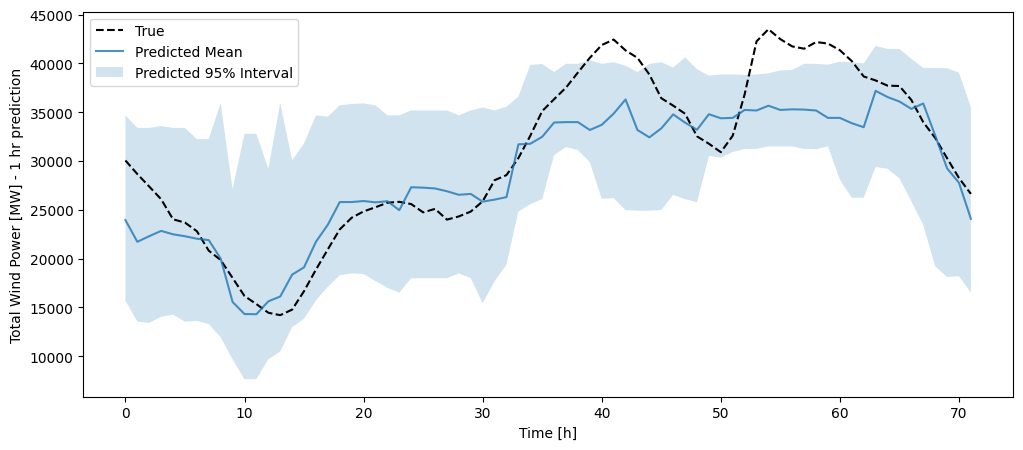

In [124]:
# plots
time_x_axis = range(72)

plt.figure(figsize=(12, 5))
plt.plot(time_x_axis,y_wind_test_1hr[:72], label='True', linestyle='--', color='black')
plt.plot(time_x_axis,predictions_2022['wind_1_hr'][:72, 1], alpha= 0.8, label='Predicted Mean')
plt.fill_between(time_x_axis, predictions_2022['wind_1_hr'][:72, 0], predictions_2022['wind_1_hr'][:72, 2], alpha=0.2, label='Predicted 95% Interval')
#plt.title('Wind Total 1 hr prediction')
plt.legend()
plt.ylabel('Total Wind Power [MW] - 1 hr prediction')
plt.xlabel('Time [h]')


plt.savefig('results/predictions_wind_1hr_2022.png', bbox_inches = 'tight')


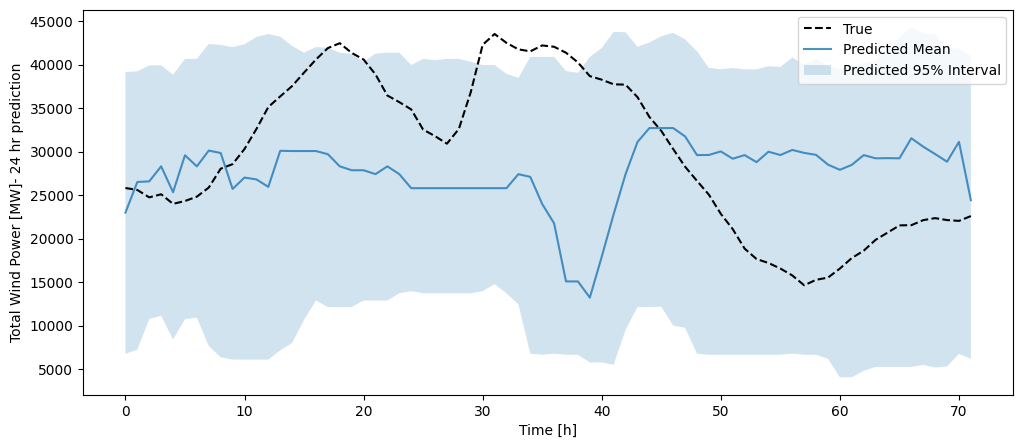

In [125]:
# plot wind total 24 hrs
plt.figure(figsize=(12, 5))
plt.plot(time_x_axis, y_wind_test_24hr[:72], label='True', linestyle='--', color='black')
plt.plot(time_x_axis, predictions_2022['wind_24_hr'][:72, 1], alpha= 0.8, label='Predicted Mean')
plt.fill_between(range(72), predictions_2022['wind_24_hr'][:72, 0], predictions_2022['wind_24_hr'][:72, 2], alpha=0.2, label='Predicted 95% Interval')
#plt.title('Wind Total 24 hr prediction')
plt.legend(loc='upper right')
plt.ylabel('Total Wind Power [MW]- 24 hr prediction')
plt.xlabel('Time [h]')

plt.savefig('results/predictions_wind_24hr_2022.png', bbox_inches = 'tight')



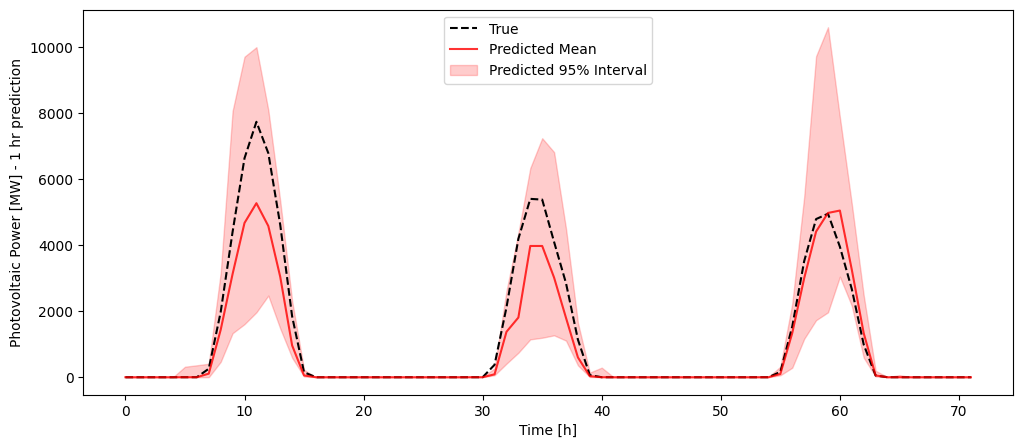

In [126]:
# photovoltaic total in red
plt.figure(figsize=(12, 5))
plt.plot(time_x_axis, y_photovoltaic_test_1_hr[:72], label='True', linestyle='--', color='black')
plt.plot(time_x_axis, predictions_2022['photovoltaic_1_hr'][:72, 1], alpha= 0.8, label='Predicted Mean', color='red') 
plt.fill_between(range(72), predictions_2022['photovoltaic_1_hr'][:72, 0], predictions_2022['photovoltaic_1_hr'][:72, 2], alpha=0.2, color='red', label='Predicted 95% Interval')
plt.legend()
plt.xlabel('Time [h]')
plt.ylabel('Photovoltaic Power [MW] - 1 hr prediction')

plt.savefig('results/predictions_pv_1hr_2022.png', bbox_inches = 'tight')



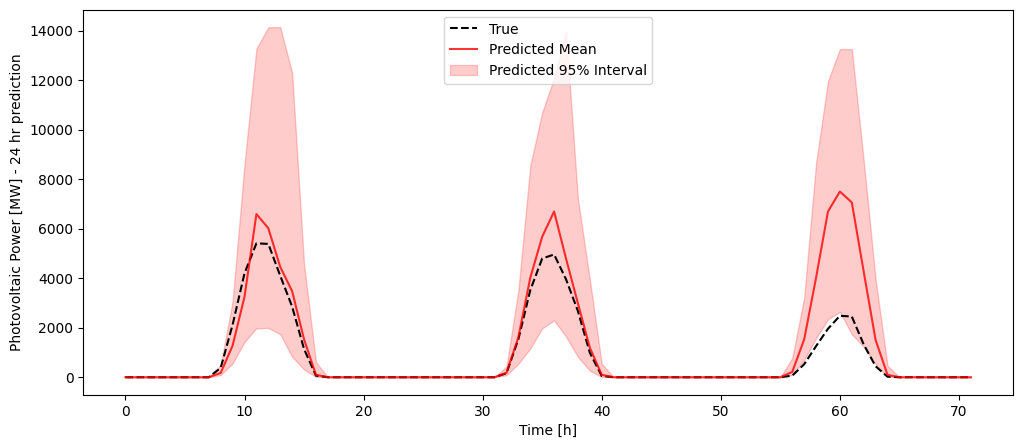

In [127]:
# photovoltaic total 24 hrs
plt.figure(figsize=(12, 5))
plt.plot(time_x_axis, y_photovoltaic_test_24_hr[:72], label='True', linestyle='--', color='black')
plt.plot(time_x_axis,  predictions_2022['photovoltaic_24_hr'][:72, 1], alpha= 0.8, label='Predicted Mean', color='red')
plt.fill_between(range(72), predictions_2022['photovoltaic_24_hr'][:72, 0], predictions_2022['photovoltaic_24_hr'][:72, 2], alpha=0.2, color='red', label='Predicted 95% Interval')
plt.legend()

plt.xlabel('Time [h]')
plt.ylabel('Photovoltaic Power [MW] - 24 hr prediction')

# save plot to results folder
plt.savefig('results/predictions_pv_24hr_2022.png', bbox_inches = 'tight')


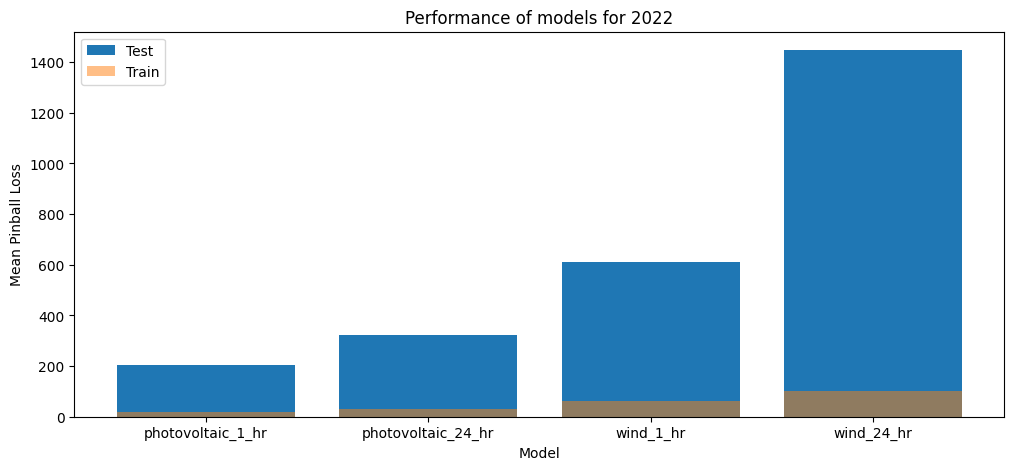

In [128]:
# plot loss scores for total wind power and photovoltaic power
df = pd.DataFrame(loss_2022, index=[0])
df = df.T
df = df.reset_index()
df.columns = ['location', 'mean_pinball_loss']
df.to_csv('results/mean_pinball_loss_2022.csv', index=False)

# make df longer for plotting
df = df.sort_values(by='mean_pinball_loss')
# get rid of offshore and onshore
"""df = df[df['location'] != 'offshore_1_hr']
df = df[df['location'] != 'offshore_24_hr']
df = df[df['location'] != 'onshore_1_hr']
df = df[df['location'] != 'onshore_24_hr']"""

# make plot for wind offshore
plt.figure(figsize=(12, 5))
plt.bar(df['location'], df['mean_pinball_loss'])
plt.title('Performance of models for 2022')
plt.ylabel('Mean Pinball Loss')
plt.xlabel('Model')

# also plot training scores
df_train = pd.DataFrame(train_scores_2022, index=[0])
df_train = df_train.T
df_train = df_train.reset_index()
df_train.columns = ['location', 'mean_train_score']
df_train = df_train.sort_values(by='mean_train_score')
# get rid of offshore and onshore
"""df_train = df_train[df_train['location'] != 'offshore_1_hr']
df_train = df_train[df_train['location'] != 'offshore_24_hr']
df_train = df_train[df_train['location'] != 'onshore_1_hr']
df_train = df_train[df_train['location'] != 'onshore_24_hr']"""

plt.bar(df_train['location'], df_train['mean_train_score'], alpha=0.5)
plt.legend(['Test', 'Train'])

# join df and df_train
df = pd.merge(df, df_train, on='location')
# save to csv
df.to_csv('results/mean_pinball_loss_2022.csv', index=False)

plt.savefig('results/mean_pinball_loss_2022.png', bbox_inches='tight')


In [129]:
# how many true values are in the prediction interval
# wind
true_wind = y_wind_test_1hr
predicted_wind_low = predictions_2022['wind_1_hr'][:, 0]
predicted_wind_high = predictions_2022['wind_1_hr'][:, 2]

true_wind_24 = y_wind_test_24hr
predicted_wind_low_24 = predictions_2022['wind_24_hr'][:, 0]
predicted_wind_high_24 = predictions_2022['wind_24_hr'][:, 2]

# photovoltaic
true_pv = y_photovoltaic_test_1_hr
predicted_pv_low = predictions_2022['photovoltaic_1_hr'][:, 0]
predicted_pv_high = predictions_2022['photovoltaic_1_hr'][:, 2]

true_pv_24 = y_photovoltaic_test_24_hr
predicted_pv_low_24 = predictions_2022['photovoltaic_24_hr'][:, 0]
predicted_pv_high_24 = predictions_2022['photovoltaic_24_hr'][:, 2]

# is true value in prediction interval
# wind
in_interval_wind = np.logical_and(true_wind >= predicted_wind_low, true_wind <= predicted_wind_high)
in_interval_24_wind = np.logical_and(true_wind_24 >= predicted_wind_low_24, true_wind_24 <= predicted_wind_high_24)

# photovoltaic
in_interval_pv = np.logical_and(true_pv >= predicted_pv_low, true_pv <= predicted_pv_high)
in_interval_24_pv = np.logical_and(true_pv_24 >= predicted_pv_low_24, true_pv_24 <= predicted_pv_high_24)

# print how many are in the interval
# how many test samples are in the 95% prediction interval
print("Amount of testing samples in 95% prediction interval")

print('Wind 1 hr prediction')
print(np.mean(in_interval_wind))
print('Wind 24 hr prediction')
print(np.mean(in_interval_24_wind))
print('Photovoltaic 1 hr prediction')
print(np.mean(in_interval_pv))
print('Photovoltaic 24 hr prediction')
print(np.mean(in_interval_24_pv))

Amount of testing samples in 95% prediction interval
Wind 1 hr prediction
0.9085512044753967
Wind 24 hr prediction
0.88003663003663
Photovoltaic 1 hr prediction
0.9138029455417285
Photovoltaic 24 hr prediction
0.9140338827838828


In [130]:
# do the train predictions lie in the 95% prediction interval
# wind
# total wind training data
train_wind_total = y_wind_1hr
# predicted total wind
train_predicted_wind_total_low = y_train_preds_2022['wind_1_hr'][:, 0]
train_predicted_wind_total_high = y_train_preds_2022['wind_1_hr'][:, 2]

train_wind_total_24 = y_wind_24hr
train_predicted_wind_total_low_24 = y_train_preds_2022['wind_24_hr'][:, 0]
train_predicted_wind_total_high_24 = y_train_preds_2022['wind_24_hr'][:, 2]

# photovoltaic
train_pv = y_photovoltaic_1_hr
train_predicted_pv_low = y_train_preds_2022['photovoltaic_1_hr'][:, 0]
train_predicted_pv_high = y_train_preds_2022['photovoltaic_1_hr'][:, 2]

train_pv_24 = y_photovoltaic_24_hr
train_predicted_pv_low_24 = y_train_preds_2022['photovoltaic_24_hr'][:, 0]
train_predicted_pv_high_24 = y_train_preds_2022['photovoltaic_24_hr'][:, 2]

# is true value in prediction interval
# wind
in_interval_train_wind = np.logical_and(train_wind_total >= train_predicted_wind_total_low, train_wind_total <= train_predicted_wind_total_high)
in_interval_train_24_wind = np.logical_and(train_wind_total_24 >= train_predicted_wind_total_low_24, train_wind_total_24 <= train_predicted_wind_total_high_24)

# photovoltaic
in_interval_train_pv = np.logical_and(train_pv >= train_predicted_pv_low, train_pv <= train_predicted_pv_high)
in_interval_train_24_pv = np.logical_and(train_pv_24 >= train_predicted_pv_low_24, train_pv_24 <= train_predicted_pv_high_24)

# print how many are in the interval
# how many test samples are in the 95% prediction interval
print("Amount of training samples in 95% prediction interval")
print('Wind 1 hr prediction')
print(np.mean(in_interval_train_wind))
print('Wind 24 hr prediction')
print(np.mean(in_interval_train_24_wind))
print('Photovoltaic 1 hr prediction')
print(np.mean(in_interval_train_pv))
print('Photovoltaic 24 hr prediction')
print(np.mean(in_interval_train_24_pv))




Amount of training samples in 95% prediction interval
Wind 1 hr prediction
1.0
Wind 24 hr prediction
1.0
Photovoltaic 1 hr prediction
1.0
Photovoltaic 24 hr prediction
1.0


/tmp/ipykernel_5263/2406988407.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = y_wind_test_1hr[sorted_indices] - predictions_2022['wind_1_hr'][sorted_indices, 0]


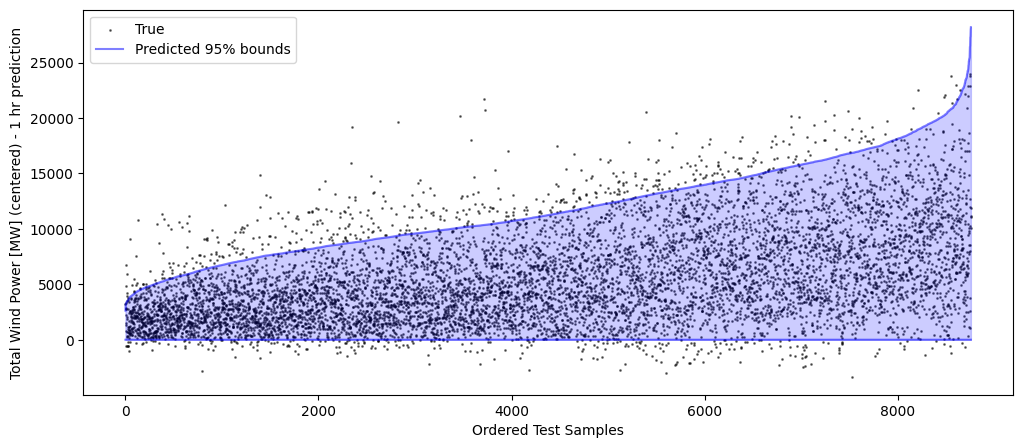

/tmp/ipykernel_5263/2406988407.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = y_wind_test_24hr[sorted_indices] - predictions_2022['wind_24_hr'][sorted_indices, 0]


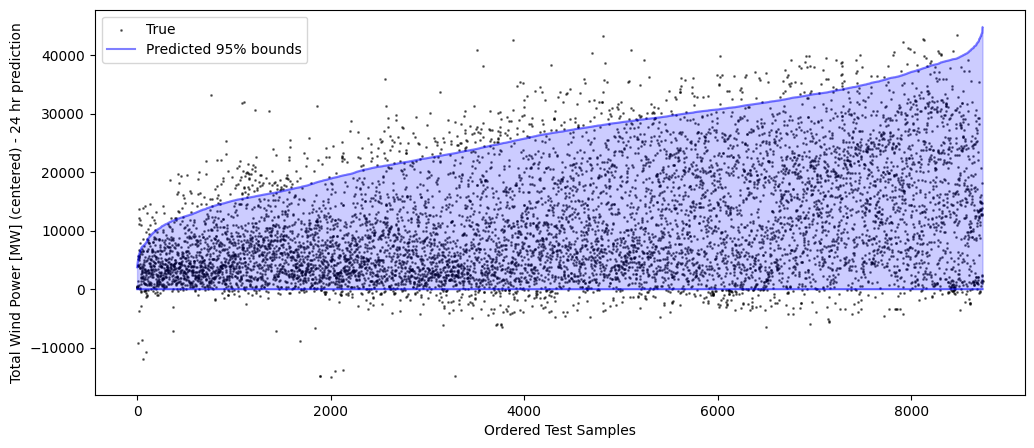

/tmp/ipykernel_5263/2406988407.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = y_photovoltaic_test_1_hr[sorted_indices] - predictions_2022['photovoltaic_1_hr'][sorted_indices, 0]


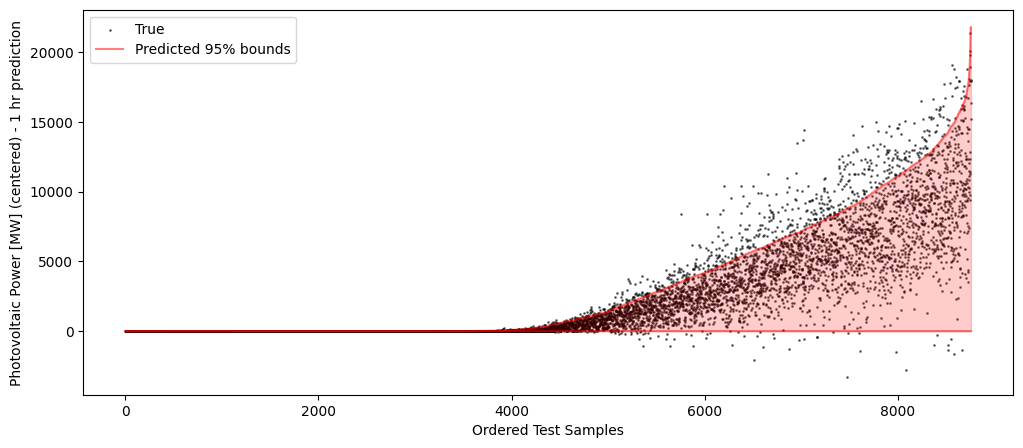

/tmp/ipykernel_5263/2406988407.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = y_photovoltaic_test_24_hr[sorted_indices] - predictions_2022['photovoltaic_24_hr'][sorted_indices, 0]


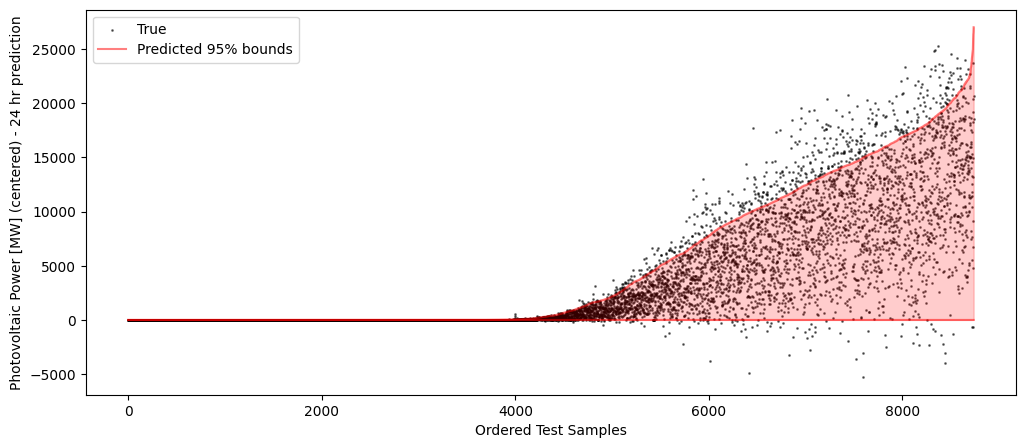

In [131]:
# wind total
# plot true values and predicted interval for test set


# sort values by size of prediction interval
sorted_indices = np.argsort(predictions_2022['wind_1_hr'][:, 2] - predictions_2022['wind_1_hr'][:, 0])
x = np.arange(sorted_indices.shape[0])

# substract mean from prediction and true values
y_test = y_wind_test_1hr[sorted_indices] - predictions_2022['wind_1_hr'][sorted_indices, 0]
predicted_low = predictions_2022['wind_1_hr'][sorted_indices, 0] - predictions_2022['wind_1_hr'][sorted_indices, 0]
predicted_high = predictions_2022['wind_1_hr'][sorted_indices, 2] - predictions_2022['wind_1_hr'][sorted_indices, 0]

plt.figure(figsize=(12, 5))
plt.scatter(x, y_test, label='True', s=1, color='black', alpha=0.5)
plt.fill_between(x, predicted_low, predicted_high, color='blue',alpha=0.2)
plt.plot(x, predicted_low, color='blue', label='Predicted 95% bounds', alpha=0.5)
plt.plot(x, predicted_high, color='blue', alpha=0.5)
#plt.suptitle('Photovoltaic 24 hr prediction')
#plt.title('Sorted by size of prediction interval and all values substracted by lower bound', fontsize=10)
plt.legend()
plt.ylabel('Total Wind Power [MW] (centered) - 1 hr prediction')
plt.xlabel('Ordered Test Samples')
plt.savefig('results/prediction_interval_wind_1hr_2022.png', bbox_inches = 'tight')
plt.show()

# 24 hrs
# sort values by size of prediction interval
sorted_indices = np.argsort(predictions_2022['wind_24_hr'][:, 2] - predictions_2022['wind_24_hr'][:, 0])
x = np.arange(sorted_indices.shape[0])

# substract mean from prediction and true values
y_test = y_wind_test_24hr[sorted_indices] - predictions_2022['wind_24_hr'][sorted_indices, 0]
predicted_low = predictions_2022['wind_24_hr'][sorted_indices, 0] - predictions_2022['wind_24_hr'][sorted_indices, 0]
predicted_high = predictions_2022['wind_24_hr'][sorted_indices, 2] - predictions_2022['wind_24_hr'][sorted_indices, 0]

plt.figure(figsize=(12, 5))
plt.scatter(x, y_test, label='True', s=1, color='black', alpha=0.5)
plt.fill_between(x, predicted_low, predicted_high, color='blue',alpha=0.2)
plt.plot(x, predicted_low, color='blue', label='Predicted 95% bounds', alpha=0.5)
plt.plot(x, predicted_high, color='blue', alpha=0.5)
#plt.suptitle('Photovoltaic 24 hr prediction')
#plt.title('Sorted by size of prediction interval and all values substracted by lower bound', fontsize=10)
plt.legend()
plt.ylabel('Total Wind Power [MW] (centered) - 24 hr prediction')
plt.xlabel('Ordered Test Samples')
plt.savefig('results/prediction_interval_wind_24hr_2022.png', bbox_inches = 'tight')
plt.show()

# photovoltaic
# sort values by size of prediction interval
sorted_indices = np.argsort(predictions_2022['photovoltaic_1_hr'][:, 2] - predictions_2022['photovoltaic_1_hr'][:, 0])
x = np.arange(sorted_indices.shape[0])

# substract mean from prediction and true values
y_test = y_photovoltaic_test_1_hr[sorted_indices] - predictions_2022['photovoltaic_1_hr'][sorted_indices, 0]
predicted_low = predictions_2022['photovoltaic_1_hr'][sorted_indices, 0] - predictions_2022['photovoltaic_1_hr'][sorted_indices, 0]
predicted_high = predictions_2022['photovoltaic_1_hr'][sorted_indices, 2] - predictions_2022['photovoltaic_1_hr'][sorted_indices, 0]

plt.figure(figsize=(12, 5))
plt.scatter(x, y_test, label='True', s=1, color='black', alpha=0.5)
plt.fill_between(x, predicted_low, predicted_high, color='red',alpha=0.2)
plt.plot(x, predicted_low, color='red', label='Predicted 95% bounds', alpha=0.5)
plt.plot(x, predicted_high, color='red', alpha=0.5)
#plt.suptitle('Photovoltaic 24 hr prediction')
#plt.title('Sorted by size of prediction interval and all values substracted by lower bound', fontsize=10)
plt.legend()
plt.ylabel('Photovoltaic Power [MW] (centered) - 1 hr prediction')
plt.xlabel('Ordered Test Samples')
plt.savefig('results/prediction_interval_pv_1hr_2022.png', bbox_inches = 'tight')
plt.show()

# 24 hrs
# sort values by size of prediction interval
sorted_indices = np.argsort(predictions_2022['photovoltaic_24_hr'][:, 2] - predictions_2022['photovoltaic_24_hr'][:, 0])
x = np.arange(sorted_indices.shape[0])

# substract mean from prediction and true values
y_test = y_photovoltaic_test_24_hr[sorted_indices] - predictions_2022['photovoltaic_24_hr'][sorted_indices, 0]
predicted_low = predictions_2022['photovoltaic_24_hr'][sorted_indices, 0] - predictions_2022['photovoltaic_24_hr'][sorted_indices, 0]
predicted_high = predictions_2022['photovoltaic_24_hr'][sorted_indices, 2] - predictions_2022['photovoltaic_24_hr'][sorted_indices, 0]

plt.figure(figsize=(12, 5))
plt.scatter(x, y_test, label='True', s=1, color='black', alpha=0.5)
plt.fill_between(x, predicted_low, predicted_high, color='red',alpha=0.2)
plt.plot(x, predicted_low, color='red', label='Predicted 95% bounds', alpha=0.5)
plt.plot(x, predicted_high, color='red', alpha=0.5)
#plt.suptitle('Photovoltaic 24 hr prediction')
#plt.title('Sorted by size of prediction interval and all values substracted by lower bound', fontsize=10)
plt.legend()
plt.ylabel('Photovoltaic Power [MW] (centered) - 24 hr prediction')
plt.xlabel('Ordered Test Samples')
plt.savefig('results/prediction_interval_pv_24hr_2022.png', bbox_inches = 'tight')
plt.show()

In [179]:
# mean interval length
# wind
mean_interval_length_wind_1_hr = np.mean(predictions_2022['wind_1_hr'][:, 2] - predictions_2022['wind_1_hr'][:, 0])
mean_interval_length_wind_24_hr = np.mean(predictions_2022['wind_24_hr'][:, 2] - predictions_2022['wind_24_hr'][:, 0])

# photovoltaic
mean_interval_length_pv_1_hr = np.mean(predictions_2022['photovoltaic_1_hr'][:, 2] - predictions_2022['photovoltaic_1_hr'][:, 0])
mean_interval_length_pv_24_hr = np.mean(predictions_2022['photovoltaic_24_hr'][:, 2] - predictions_2022['photovoltaic_24_hr'][:, 0])

print('Mean interval length')
print('Wind 1 hr prediction')
print(mean_interval_length_wind_1_hr)
print('Wind 24 hr prediction')
print(mean_interval_length_wind_24_hr)
print('Photovoltaic 1 hr prediction')
print(mean_interval_length_pv_1_hr)
print('Photovoltaic 24 hr prediction')
print(mean_interval_length_pv_24_hr)


Mean interval length
Wind 1 hr prediction
11848.602457472307
Wind 24 hr prediction
25905.364353680165
Photovoltaic 1 hr prediction
3247.557101980819
Photovoltaic 24 hr prediction
5130.60891426282


/tmp/ipykernel_5263/681431518.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = y_wind_1hr[sorted_indices] - y_train_preds_2022['wind_1_hr'][sorted_indices, 0]


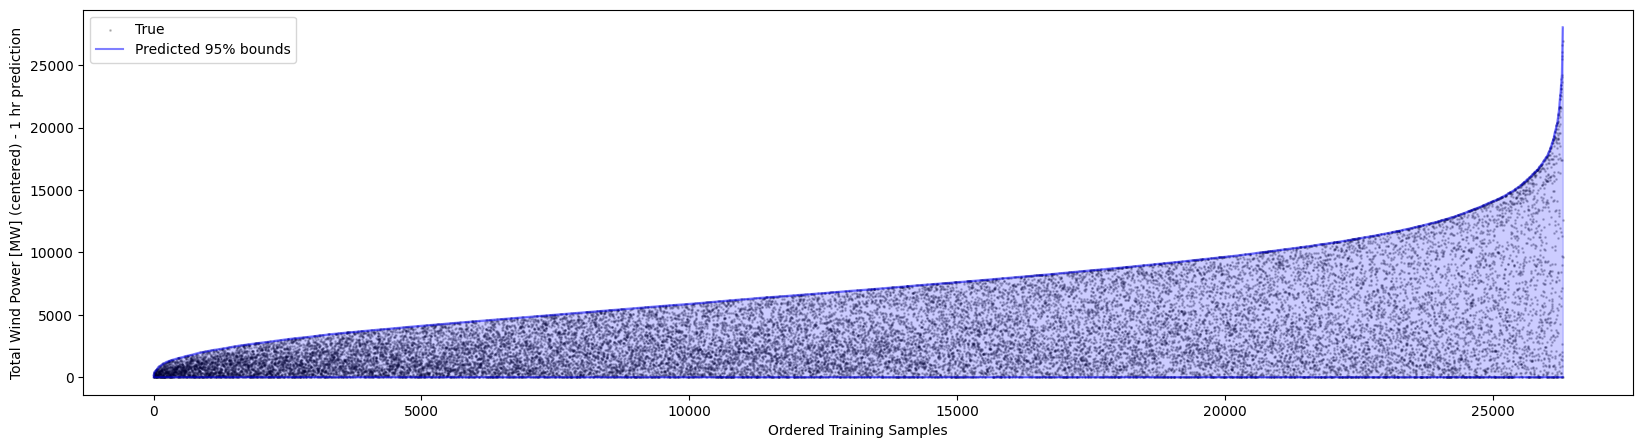

/tmp/ipykernel_5263/681431518.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = y_wind_24hr[sorted_indices] - y_train_preds_2022['wind_24_hr'][sorted_indices, 0]


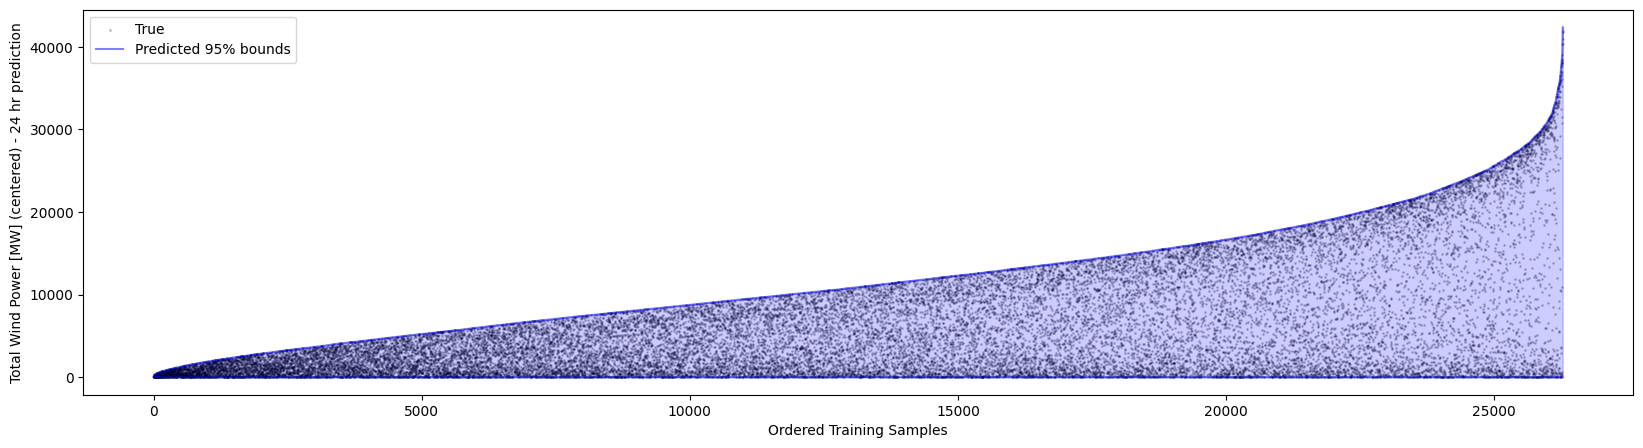

/tmp/ipykernel_5263/681431518.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = y_photovoltaic_1_hr[sorted_indices] - y_train_preds_2022['photovoltaic_1_hr'][sorted_indices, 0]


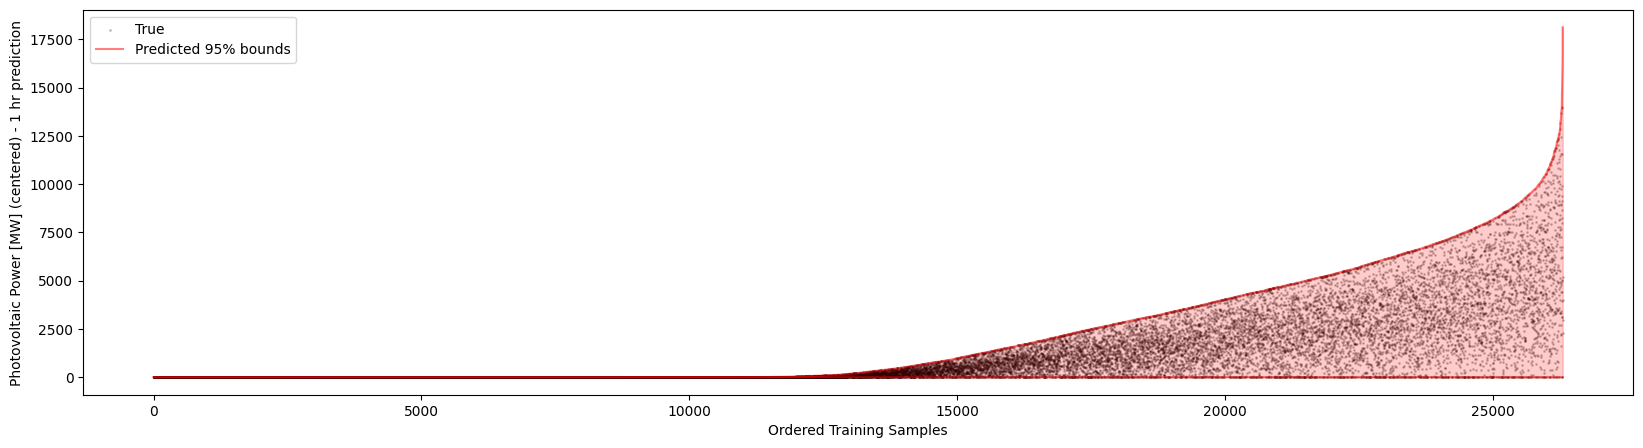

/tmp/ipykernel_5263/681431518.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = y_photovoltaic_24_hr[sorted_indices] - y_train_preds_2022['photovoltaic_24_hr'][sorted_indices, 0]


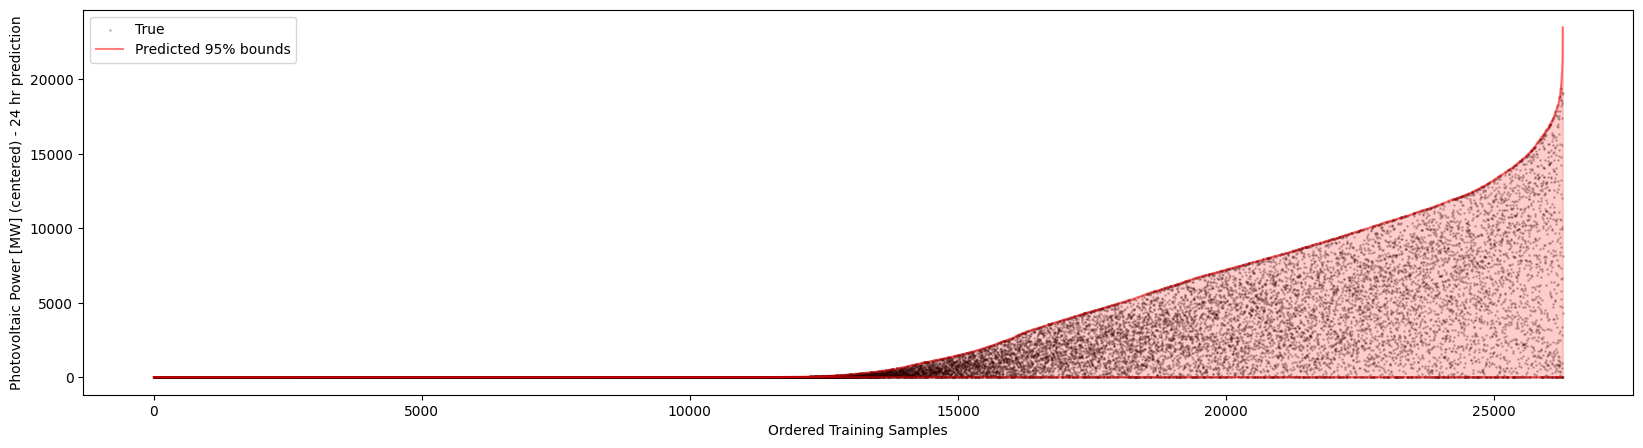

In [132]:
# test the same thing for training data
# wind
# sort values by size of prediction interval
sorted_indices = np.argsort(y_train_preds_2022['wind_1_hr'][:, 2] - y_train_preds_2022['wind_1_hr'][:, 0])
x = np.arange(sorted_indices.shape[0])

# substract mean from prediction and true values
y_test = y_wind_1hr[sorted_indices] - y_train_preds_2022['wind_1_hr'][sorted_indices, 0]
predicted_low = y_train_preds_2022['wind_1_hr'][sorted_indices, 0] - y_train_preds_2022['wind_1_hr'][sorted_indices, 0]
predicted_high = y_train_preds_2022['wind_1_hr'][sorted_indices, 2] - y_train_preds_2022['wind_1_hr'][sorted_indices, 0]

plt.figure(figsize=(20, 5))
plt.scatter(x, y_test, label='True', s=1, color='black', alpha=0.2)
plt.fill_between(x, predicted_low, predicted_high, color='blue',alpha=0.2)
plt.plot(x, predicted_low, color='blue', label='Predicted 95% bounds', alpha=0.5)
plt.plot(x, predicted_high, color='blue', alpha=0.5)

plt.legend()
plt.ylabel('Total Wind Power [MW] (centered) - 1 hr prediction')
plt.xlabel('Ordered Training Samples')
plt.show()

# 24 hrs
# sort values by size of prediction interval
sorted_indices = np.argsort(y_train_preds_2022['wind_24_hr'][:, 2] - y_train_preds_2022['wind_24_hr'][:, 0])
x = np.arange(sorted_indices.shape[0])

# substract mean from prediction and true values
y_test = y_wind_24hr[sorted_indices] - y_train_preds_2022['wind_24_hr'][sorted_indices, 0]
predicted_low = y_train_preds_2022['wind_24_hr'][sorted_indices, 0] - y_train_preds_2022['wind_24_hr'][sorted_indices, 0]
predicted_high = y_train_preds_2022['wind_24_hr'][sorted_indices, 2] - y_train_preds_2022['wind_24_hr'][sorted_indices, 0]

plt.figure(figsize=(20, 5))
plt.scatter(x, y_test, label='True', s=1, color='black', alpha=0.2)
plt.fill_between(x, predicted_low, predicted_high, color='blue',alpha=0.2)
plt.plot(x, predicted_low, color='blue', label='Predicted 95% bounds', alpha=0.5)
plt.plot(x, predicted_high, color='blue', alpha=0.5)

plt.legend()
plt.ylabel('Total Wind Power [MW] (centered) - 24 hr prediction')

plt.xlabel('Ordered Training Samples')
plt.show()

# photovoltaic
# sort values by size of prediction interval
sorted_indices = np.argsort(y_train_preds_2022['photovoltaic_1_hr'][:, 2] - y_train_preds_2022['photovoltaic_1_hr'][:, 0])
x = np.arange(sorted_indices.shape[0])


# substract mean from prediction and true values
y_test = y_photovoltaic_1_hr[sorted_indices] - y_train_preds_2022['photovoltaic_1_hr'][sorted_indices, 0]
predicted_low = y_train_preds_2022['photovoltaic_1_hr'][sorted_indices, 0] - y_train_preds_2022['photovoltaic_1_hr'][sorted_indices, 0]
predicted_high = y_train_preds_2022['photovoltaic_1_hr'][sorted_indices, 2] - y_train_preds_2022['photovoltaic_1_hr'][sorted_indices, 0]

plt.figure(figsize=(20, 5))
plt.scatter(x, y_test, label='True', s=1, color='black', alpha=0.2)
plt.fill_between(x, predicted_low, predicted_high, color='red',alpha=0.2)

plt.plot(x, predicted_low, color='red', label='Predicted 95% bounds', alpha=0.5)
plt.plot(x, predicted_high, color='red', alpha=0.5)

plt.legend()
plt.ylabel('Photovoltaic Power [MW] (centered) - 1 hr prediction')
plt.xlabel('Ordered Training Samples')
plt.show()

# 24 hrs
# sort values by size of prediction interval
sorted_indices = np.argsort(y_train_preds_2022['photovoltaic_24_hr'][:, 2] - y_train_preds_2022['photovoltaic_24_hr'][:, 0])
x = np.arange(sorted_indices.shape[0])

# substract mean from prediction and true values
y_test = y_photovoltaic_24_hr[sorted_indices] - y_train_preds_2022['photovoltaic_24_hr'][sorted_indices, 0]
predicted_low = y_train_preds_2022['photovoltaic_24_hr'][sorted_indices, 0] - y_train_preds_2022['photovoltaic_24_hr'][sorted_indices, 0]
predicted_high = y_train_preds_2022['photovoltaic_24_hr'][sorted_indices, 2] - y_train_preds_2022['photovoltaic_24_hr'][sorted_indices, 0]

plt.figure(figsize=(20, 5))
plt.scatter(x, y_test, label='True', s=1, color='black', alpha=0.2)
plt.fill_between(x, predicted_low, predicted_high, color='red',alpha=0.2)
plt.plot(x, predicted_low, color='red', label='Predicted 95% bounds', alpha=0.5)
plt.plot(x, predicted_high, color='red', alpha=0.5)

plt.legend()
plt.ylabel('Photovoltaic Power [MW] (centered) - 24 hr prediction')
plt.xlabel('Ordered Training Samples')
plt.show()

In [183]:
# mean interval length
# wind
mean_interval_length_wind_1_hr_train = np.mean(y_train_preds_2022['wind_1_hr'][:, 2] - y_train_preds_2022['wind_1_hr'][:, 0])
mean_interval_length_wind_24_hr_train = np.mean(y_train_preds_2022['wind_24_hr'][:, 2] - y_train_preds_2022['wind_24_hr'][:, 0])

# photovoltaic
mean_interval_length_pv_1_hr_train = np.mean(y_train_preds_2022['photovoltaic_1_hr'][:, 2] - y_train_preds_2022['photovoltaic_1_hr'][:, 0])
mean_interval_length_pv_24_hr_train = np.mean(y_train_preds_2022['photovoltaic_24_hr'][:, 2] - y_train_preds_2022['photovoltaic_24_hr'][:, 0])

print('Mean interval length')
print('Wind 1 hr prediction')
print(mean_interval_length_wind_1_hr_train)
print('Wind 24 hr prediction')
print(mean_interval_length_wind_24_hr_train)
print('Photovoltaic 1 hr prediction')
print(mean_interval_length_pv_1_hr_train)
print('Photovoltaic 24 hr prediction')
print(mean_interval_length_pv_24_hr_train)

mean_interval_fraction_train_vs_test = np.mean([mean_interval_length_wind_1_hr / mean_interval_length_wind_1_hr_train, mean_interval_length_wind_24_hr / mean_interval_length_wind_24_hr_train,
                                            mean_interval_length_pv_1_hr / mean_interval_length_pv_1_hr_train, mean_interval_length_pv_24_hr / mean_interval_length_pv_24_hr_train])

# how much longer are the prediction intervals in the test set
print('How much longer are the prediction intervals in the test set compared to the training set?')
print(mean_interval_fraction_train_vs_test - 1)

mean_interval_fraction_1hr_vs_24hr_test = np.mean([mean_interval_length_wind_24_hr / mean_interval_length_wind_1_hr, mean_interval_length_pv_24_hr / mean_interval_length_pv_1_hr])
print('How much longer are the prediction intervals for 1 hr predictions compared to 24 hr predictions on test set?')
print(mean_interval_fraction_1hr_vs_24hr_test - 1)

mean_interval_fraction_1hr_vs_24hr_train = np.mean([mean_interval_length_wind_24_hr_train / mean_interval_length_wind_1_hr_train, mean_interval_length_pv_24_hr_train / mean_interval_length_pv_1_hr_train])
print('How much longer are the prediction intervals for 1 hr predictions compared to 24 hr predictions on training set?')
print(mean_interval_fraction_1hr_vs_24hr_train - 1)


Mean interval length
Wind 1 hr prediction
7397.108096985128
Wind 24 hr prediction
11946.901625047556
Photovoltaic 1 hr prediction
2110.994739906093
Photovoltaic 24 hr prediction
3538.5785235920835
How much longer are the prediction intervals in the test set compared to the training set?
0.689617919997739
How much longer are the prediction intervals for 1 hr predictions compared to 24 hr predictions on test set?
0.8831004728821816
How much longer are the prediction intervals for 1 hr predictions compared to 24 hr predictions on training set?
0.645669254639571
